In [140]:
%pip install netCDF4
%pip install zstandard
%pip install numcodecs

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [141]:
import os
from netCDF4 import Dataset
import zstandard as zstd
import numcodecs
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [142]:
def read_file_with_var(read_file_name, var_name):
    data = Dataset("data/" + read_file_name)

    var = data.variables[var_name]
    var_data = var[:]

    output = var_data.tobytes()

    write_path = "data/output/binary/" + read_file_name + "_" + var_name + ".bin"
    os.makedirs(os.path.dirname(write_path), exist_ok=True)

    with open(write_path, "wb") as file:
        file.write(output)
        print(f"File written to {write_path}")

    data.close()

In [143]:
def zstd_compress(file_name):
    cctx = zstd.ZstdCompressor()

    with open(file_name, "rb") as file:
        file_data = file.read()
    
    compressed = cctx.compress(file_data)
    return compressed

In [144]:
def zlib_compress(file_name):
    with open(file_name, "rb") as file:
        file_data = file.read()
    
    zlib = numcodecs.Zlib(level=9)
    compressed = zlib.encode(file_data)
    return compressed

In [145]:
def gzip_compress(file_name):
    with open(file_name, "rb") as file:
        file_data = file.read()
    
    gzip = numcodecs.gzip.GZip(level=9)
    compressed = gzip.encode(file_data)
    return compressed

In [146]:
def blosc_compress(file_name):
    with open(file_name, "rb") as file:
        file_data = file.read()
    
    blosc = numcodecs.Blosc(cname="blosclz", clevel=9, shuffle=numcodecs.blosc.Blosc.BITSHUFFLE, blocksize=0)
    compressed = blosc.encode(file_data)
    return compressed

In [147]:
def get_file_size(file_name, compressed):
    file_size = len(file_name)
    return file_size

In [148]:
def compression_ratio(original_file, compressed_file,):
    original_size = get_file_size(original_file, False)
    compressed_size = get_file_size(compressed_file, True)

    ratio = original_size / compressed_size

    data = [original_size, compressed_size, ratio]
    return data

In [149]:
def compress_all_vars(read_file_name):
    data = Dataset("data/" + read_file_name)
    compression_ratios = {}
    size_comparison = {}

    for var_name in data.variables.keys():
        uncompressed_file_path = "data/output/binary/" + read_file_name + "_" + var_name + ".bin"
        read_file_with_var(read_file_name, var_name)

        zstd_compressed_obj = zstd_compress(uncompressed_file_path)
        zstd_compression_data = compression_ratio(uncompressed_file_path, zstd_compressed_obj)

        zlib_compressed_obj = zlib_compress(uncompressed_file_path)
        zlib_compression_data = compression_ratio(uncompressed_file_path, zlib_compressed_obj)

        gzip_compressed_obj = gzip_compress(uncompressed_file_path)
        gzip_compression_data = compression_ratio(uncompressed_file_path, gzip_compressed_obj)

        blosc_compressed_obj = blosc_compress(uncompressed_file_path)
        blosc_compression_data = compression_ratio(uncompressed_file_path, blosc_compressed_obj)

        compression_ratios[var_name] = {
            "zstd_ratio": zstd_compression_data[2],
            "zlib_ratio": zlib_compression_data[2],
            "gzip_ratio": gzip_compression_data[2],
            "blosc_ratio": blosc_compression_data[2]
        }

        size_comparison[var_name] = {
            "original": zstd_compression_data[0],
            "zstd": zstd_compression_data[1],
            "zlib": zlib_compression_data[1],
            "gzip": gzip_compression_data[1],
            "blosc": blosc_compression_data[1]
        }

    data.close()

    ratio_write_path = "data/output/ratios/" + read_file_name + "_ratios.json"
    comparison_write_path = "data/output/comparison/" + read_file_name + "_comparison.json"
    os.makedirs(os.path.dirname(ratio_write_path), exist_ok=True)
    os.makedirs(os.path.dirname(comparison_write_path), exist_ok=True)
    
    with open(ratio_write_path, "w") as outfile:
        json.dump(compression_ratios, outfile, indent=4)
        print(f"Compression ratios written to {ratio_write_path}")
    
    with open(comparison_write_path, "w") as outfile:
        json.dump(size_comparison, outfile, indent=4)
        print(f"File size comparisons written to {comparison_write_path}")

In [150]:
compress_all_vars("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")
# compress_all_vars("GEOS.fp.asm.inst1_2d_lfo_Nx.20210321_0700.V01.nc4")

File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon.bin
File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lat.bin
File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_time.bin
File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_HLML.bin
File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_PS.bin
File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_QLML.bin
File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_SPEEDLML.bin
File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_TLML.bin
File written to data/output/binary/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_TAITIME.bin
Compression ratios written to data/output/ratios/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_ratios.json
File size comparisons written to data/ou

In [151]:
def ratio_plot(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data = json.load(file)

                    keys = list(data.keys())
                    libraries = list(data[keys[0]].keys())
                    
                    ratios = {lib: [data[key][lib] for key in keys] for lib in libraries}

                    x = np.arange(len(keys))
                    width = 0.8 / len(libraries)

                    fig, ax = plt.subplots(figsize=(12, 6))

                    for i, lib in enumerate(libraries):
                        ax.bar(x + (i - len(libraries)/2) * width, ratios[lib], width, label=lib)

                    ax.set_xlabel('Variable')
                    ax.set_ylabel('Compression Ratio')
                    ax.set_title('Variable Compression Ratios by Library')
                    ax.set_xticks(x)
                    ax.set_xticklabels(keys, rotation=45)
                    ax.legend()

                    plt.tight_layout()

                    output_dir = "data/output/ratios/"
                    os.makedirs(output_dir, exist_ok=True)
                    plt.savefig(os.path.join(output_dir, filename.replace('.json', '.png')))
                    plt.show()

In [152]:
def comparison_plot(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data = json.load(file)

                    keys = list(data.keys())
                    libraries = [lib for lib in data[keys[0]].keys() if lib != "original"]
                    
                    original_values = [data[key]['original'] for key in keys]
                    
                    compressed_values = {lib: [data[key][lib] for key in keys] for lib in libraries}

                    x = np.arange(len(keys))
                    width = 0.8 / (len(libraries) + 1)

                    fig, ax = plt.subplots(figsize=(12, 6))

                    ax.bar(x - len(libraries)/2 * width, original_values, width, label='Original', color='skyblue')

                    for i, lib in enumerate(libraries):
                        ax.bar(x + (i - len(libraries)/2) * width, compressed_values[lib], width, label=lib)

                    ax.set_xlabel('Keys')
                    ax.set_ylabel('Size')
                    ax.set_title('Original vs Compressed Sizes by Library')
                    ax.set_xticks(x)
                    ax.set_xticklabels(keys, rotation=45)
                    ax.legend()

                    plt.tight_layout()

                    output_dir = "data/output/comparison/"
                    os.makedirs(output_dir, exist_ok=True)
                    plt.savefig(os.path.join(output_dir, filename.replace('.json', '.png')))
                    plt.show()

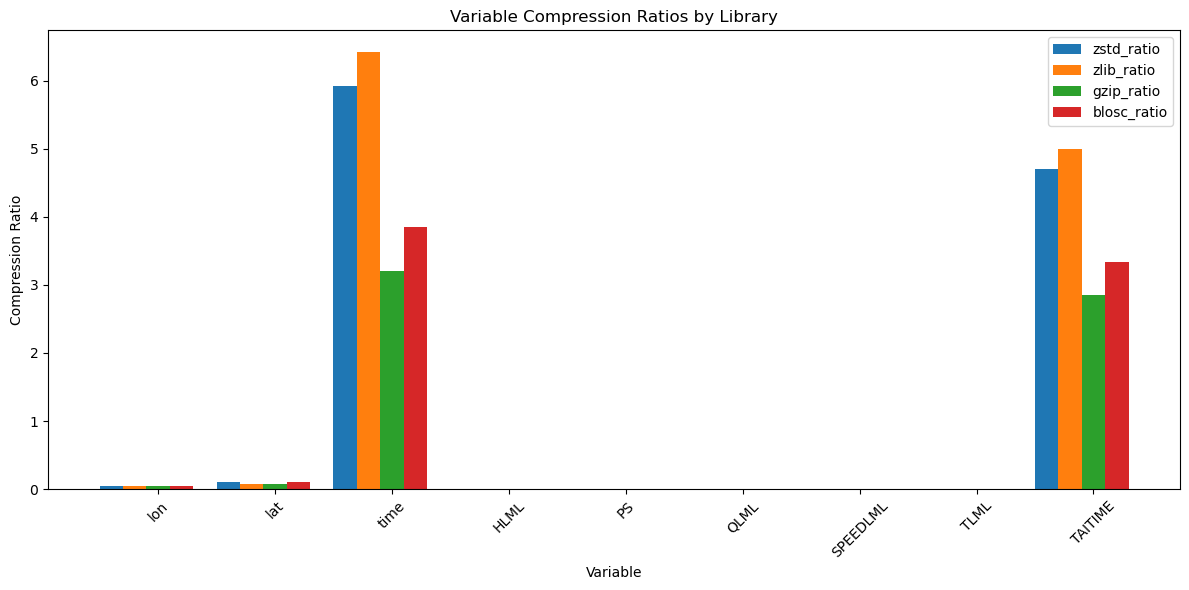

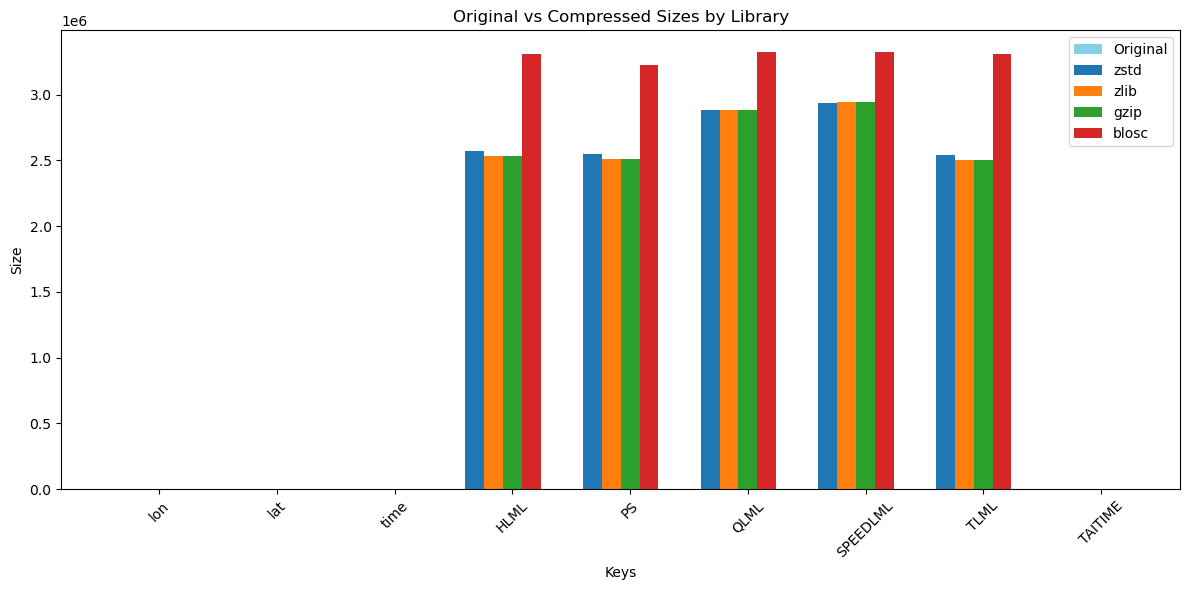

In [153]:
ratio_plot("data/output/ratios")
comparison_plot("data/output/comparison")